# SimpleRNN을 이용한 SMS Spam 분류
- 캐글에서 제공하는 스팸메일 데이터(https://www.kaggle.com/uciml/sms-spam-collection-dataset)

In [1]:
import numpy as np 
import tensorflow as tf 
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [3]:
df = pd.read_csv('data/spam.csv', encoding='latin1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


### 데이터 전처리

In [4]:
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']
df['v1'] = df.v1.replace(['ham', 'spam'], [0,1])
df.head(3)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [7]:
# Null 값이 있는지 확인
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [ ]:
"""# 결측치 삭제
df.dropna(axis=0) # 결측치 있는 행
df.dropna(axis=1) # 결측치 있는 열"""

In [8]:
# 데이터 중복 여부 확인
df.v2.nunique()

5169

In [9]:
# 중복 데이터 제거
df = df.drop_duplicates('v2', keep='first')

In [10]:
# Ham/Spam 데이터 갯수 확인
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [13]:
X_data = df.v2.values
y_data = df.v1.values
len(X_data), y_data.shape

(5169, (5169,))

### 텍스트 전처리

In [16]:
# 구둣점 제거, 소문자로 변환
from string import punctuation

def preprocessing(s):
    s = s.encode('utf8').decode('ascii', 'ignore')
    return ''.join(c for c in s if c not in punctuation).lower()

In [15]:
X_data = [preprocessing(s) for s in X_data]
X_data[2]

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'

In [20]:
# 단어 집합을 만들고, 그 크기를 확인
t = Tokenizer()
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) + 1
vocab_size

9480

In [21]:
# 학습에 사용될 샘플 시퀀스
sequences = t.texts_to_sequences(X_data)
print(sequences[2])

[54, 508, 8, 22, 4, 959, 960, 2, 217, 2566, 1291, 664, 2567, 2568, 268, 2569, 71, 2566, 2, 2570, 2, 336, 508, 3838, 84, 3839, 424, 3840]


In [23]:
max_len = max(len(l) for l in sequences)
max_len

171

In [24]:
# 전체 데이터셋의 길이를 max_len(171)에 맞추기
data = pad_sequences(sequences, maxlen=max_len)
data.shape

(5169, 171)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, y_data, stratify=y_data, test_size=0.2, random_state=seed
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

### 모델 정의/설정/학습

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

In [27]:
model = Sequential([
    Embedding(vocab_size, 32, input_length=max_len),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 171, 32)           303360    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 305,473
Trainable params: 305,473
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']
)

In [29]:
history = model.fit(X_train, y_train, epochs=10,
                    batch_size=60, validation_split=0.2)

Epoch 1/10
56/56 [==============================] - 2s 31ms/step - loss: 0.4089 - accuracy: 0.8643 - val_loss: 0.3347 - val_accuracy: 0.8948
Epoch 2/10
56/56 [==============================] - 1s 23ms/step - loss: 0.1725 - accuracy: 0.9550 - val_loss: 0.0915 - val_accuracy: 0.9794
Epoch 3/10
56/56 [==============================] - 1s 23ms/step - loss: 0.0738 - accuracy: 0.9813 - val_loss: 0.0760 - val_accuracy: 0.9819
Epoch 4/10
56/56 [==============================] - 1s 24ms/step - loss: 0.0366 - accuracy: 0.9918 - val_loss: 0.0641 - val_accuracy: 0.9831
Epoch 5/10
56/56 [==============================] - 1s 25ms/step - loss: 0.0167 - accuracy: 0.9979 - val_loss: 0.0666 - val_accuracy: 0.9843
Epoch 6/10
56/56 [==============================] - 1s 26ms/step - loss: 0.0101 - accuracy: 0.9988 - val_loss: 0.0663 - val_accuracy: 0.9843
Epoch 7/10
56/56 [==============================] - 1s 24ms/step - loss: 0.0097 - accuracy: 0.9982 - val_loss: 0.0681 - val_accuracy: 0.9831
Epoch 8/10
56

In [30]:
model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 5ms/step - loss: 0.0740 - accuracy: 0.9797


[0.07403256744146347, 0.9796905517578125]

### 학습과정 시각화

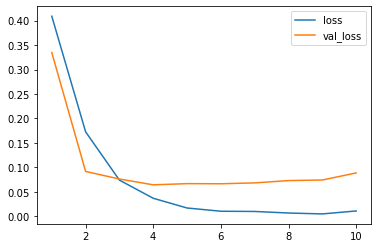

In [31]:
y_loss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = range(1, len(y_loss)+1)
plt.plot(x_len, y_loss, label='loss')
plt.plot(x_len, y_vloss, label='val_loss')
plt.legend()
plt.show()